In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.metrics import AUC, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, \
     roc_curve, roc_auc_score

from _common import NUM_LABEL_COLS, RANDOM_SEED
from _alto_tenor_lmsc import TEST_SIZE, VALIDATION_SIZE, \
    BANDS, TIME_SLICES, master, lmss, data, target
# Note that records are read from pickle, selected, filtered,
# and scaled with `sklearn.preprocessing.StandardScaler` 
# in `_alto_tenor_lmsc.py`.

In [5]:
print(data.shape)
print(target.shape)

(6485, 9216)
(6485,)


In [6]:
x_train, x_test, y_train, y_test = \
     train_test_split(data, target,
                      test_size=TEST_SIZE,
                      random_state=RANDOM_SEED)

In [10]:
TIME_SLICES = 96

In [11]:
# Reshape for input to 2D convolutional layer
x_train = x_train.reshape(x_train.shape[0], BANDS, TIME_SLICES, 1)
x_test = x_test.reshape(x_test.shape[0], BANDS, TIME_SLICES, 1)

In [13]:
dependencies = {
    'recall': Recall
}

fn = './keras_models/tenor_cnn_brass_ok/alto_tenor_cnn_F.h5'
model = load_model(fn, custom_objects=dependencies, compile=False)

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[Recall(name='recall'), 'accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# ONLY RETRAIN IF NECESSARY
NUM_EPOCHS = 12
BATCH_SIZE = 32
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION_SIZE)

Train on 4150 samples, validate on 1038 samples
Epoch 1/12
1888/4150 [============>.................] - ETA: 1:02 - loss: 0.0587 - recall: 0.9834 - accuracy: 0.9836

In [19]:
# auc, 
loss, recall, accuracy = model.evaluate(x_test, y_test)
# print('AUC: %.2f' % (auc * 100))
print('Recall: %.2f' % (recall * 100))
print('Accuracy: %.2f' % (accuracy * 100))

1297/1297 [==============================] - 7s 6ms/step
Recall: 95.21
Accuracy: 95.53


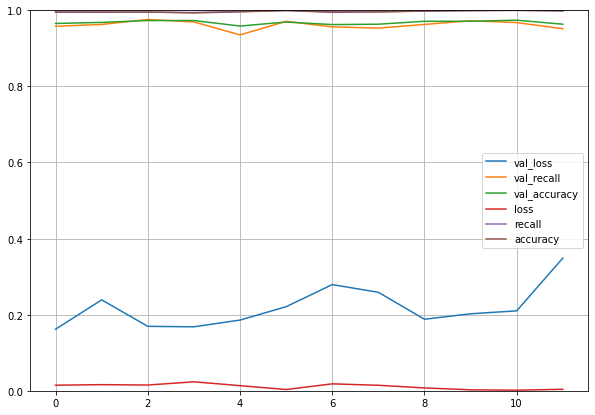

In [20]:
# history is a keras.callbacks.callbacks.History object
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [21]:
# fn = './keras_models/tenor_cnn_brass_ok/alto_tenor_cnn_F.h5'
model.save(fn)

In [22]:
probas_pred = model.predict_proba(x_test)

In [28]:
# y_true = [1 if x == '1' else 0 for x in y_test]
y_true = y_test

In [29]:
precision, recall, threshold = precision_recall_curve(y_true, probas_pred)

Text(0.5, 1.0, 'Precision-Recall Curve')

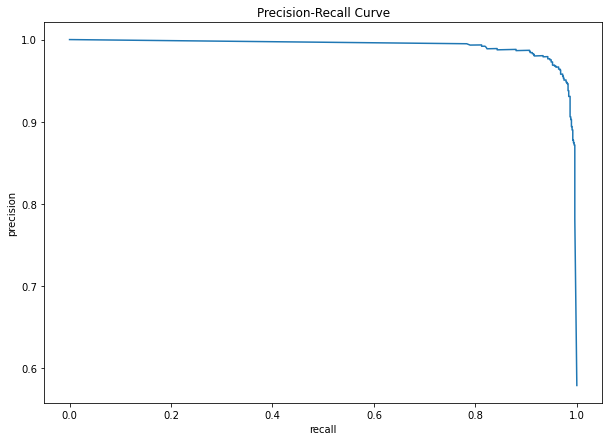

In [30]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("Precision-Recall Curve")


In [31]:
fpr, tpr, threshold = roc_curve(y_true, probas_pred)
auc = roc_auc_score(y_true, probas_pred)

Text(0.5, 1.0, 'ROC Curve: AUC = 0.989')

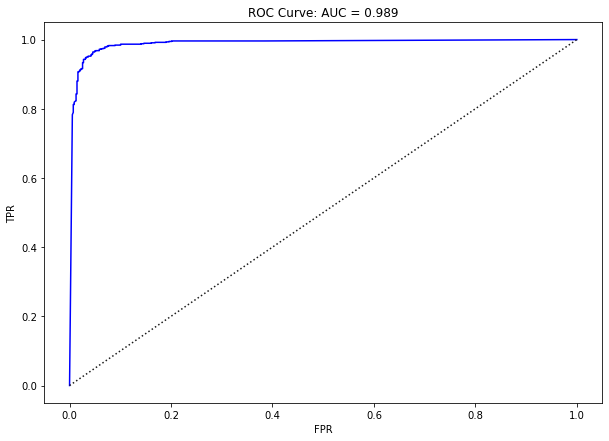

In [32]:
fig = plt.figure(figsize=(10, 7))    
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1], ':', color='0.1')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve: AUC = {:.3f}".format(auc)) 